<a href="https://colab.research.google.com/github/arthurcarvalhoc/pm4py_tests/blob/main/pm4py_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!wget https://gitlab.com/healthcare2/process-mining-tutorial/-/raw/master/ArtificialPatientTreatment.csv

--2022-12-07 20:25:48--  https://gitlab.com/healthcare2/process-mining-tutorial/-/raw/master/ArtificialPatientTreatment.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37808 (37K) [text/plain]
Saving to: ‘ArtificialPatientTreatment.csv’

ArtificialPatientTr 100%[===================>]  36.92K  --.-KB/s    in 0s      

2022-12-07 20:25:48 (121 MB/s) - ‘ArtificialPatientTreatment.csv’ saved [37808/37808]



In [14]:
!pip install pm4py pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ArtificialPatientTreatment.csv has 690 rows and 4 columns.


**Minimum number of events per case**: 6

**First doctor**:  Dr. Bob

**Last doctor**:  Dr. Ben

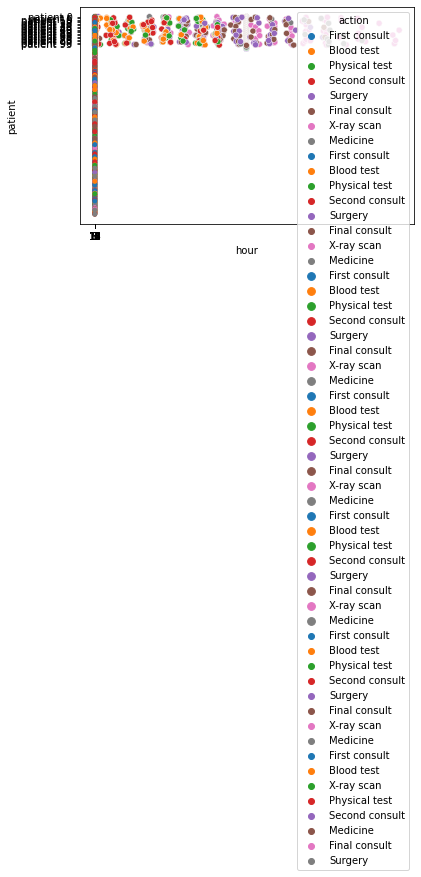

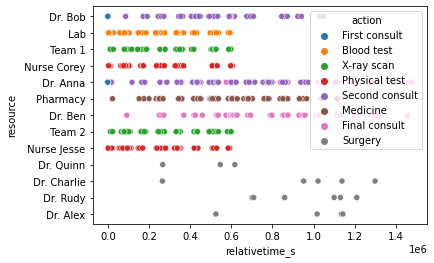

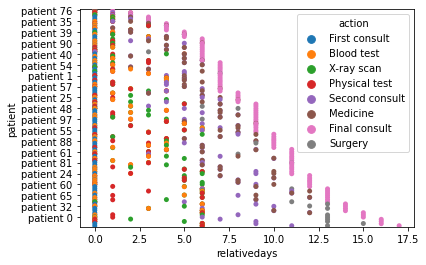

interactive(children=(Dropdown(description='x', options=('patient 0', 'patient 1', 'patient 2', 'patient 3', '…

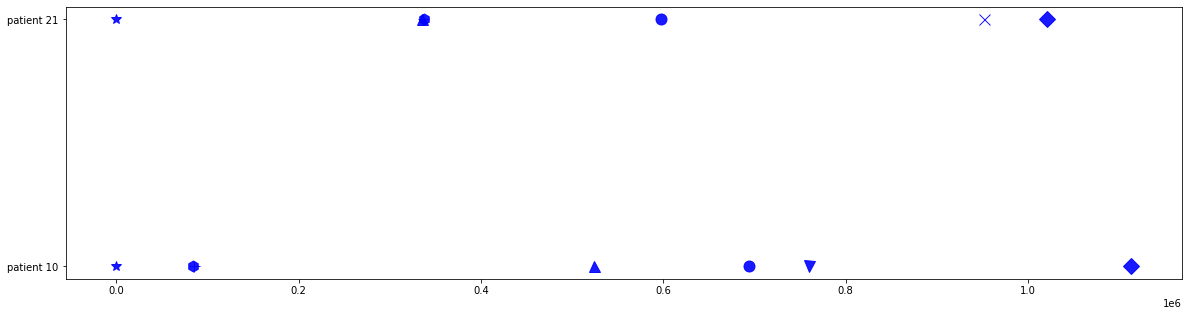

In [12]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
  
  

def printmd(string):
    display(Markdown(string))

fn = 'ArtificialPatientTreatment.csv'
events = pd.read_csv(fn)

events.columns = ['patient', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])
events.head()
print('{} has {} rows and {} columns.'.format(fn, events.shape[0], events.shape[1]))
  ## Get the case start times to get the time deltas for the 'age' of each activity with respect to start
case_starts_ends = events.pivot_table(index='patient', aggfunc={'datetime': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart']
events = events.merge(case_starts_ends, on='patient')
events['relativetime'] = events['datetime'] - events['casestart']
events.head()  

events['action'] = events['action'].apply(lambda x: x.strip())  

delimiter = '___'

makeEventString = lambda x: delimiter.join(x)
makeEventString.__name__ = 'makeEventString'

numEvents = lambda x: len(x)
numEvents.__name__ = 'numEvents'


caselogs = events.pivot_table(index='patient', aggfunc={'action': [makeEventString, numEvents]})
caselogs = caselogs.reset_index()
caselogs.columns = ['patient', 'action_sequence', 'numactions']

events = pd.merge(events, caselogs, on='patient')
events['caselength'] = events['caseend'] - events['casestart']

events.head()
  ## Get day of week
events['weekday'] = events['datetime'].apply(lambda x: x.weekday())
events['date'] = events['datetime'].apply(lambda x: x.date())
events['startdate'] = events['casestart'].apply(lambda x: x.date())
events['hour'] = events['datetime'].apply(lambda x: x.time().hour)
## Get relative times in more friendly terms
events['relativetime_s'] = events['relativetime'].dt.seconds + 86400*events['relativetime'].dt.days
events['relativedays'] = events['relativetime'].dt.days

events.head()    

#Questions
#What is the minimum number of events per case?
printmd('**Minimum number of events per case**: {}'.format(min(events['patient'].value_counts())))  
#Patient 26

#Which doctor did s/he have his/her consultation with?Which doctor did s/he have his/her consultation with?
 
first_doctor = events[events['datetime']==min(events[events['patient']=='patient 26']['datetime'])]['resource'].values[0]
last_doctor = events[events['datetime']==max(events[events['patient']=='patient 26']['datetime'])]['resource'].values[0]
printmd('**First doctor**: {}'.format(first_doctor))
printmd('**Last doctor**: {}'.format(last_doctor))

#  Which activity has the lowest occurrence overall in the event log?
#  printmd('**Activity with lowest occurrence**: {}'.format(events['action'].value_counts().sort_values().idxmin()))  Visualisations
 
activities = list(events['action'].unique())
markers = ['*', '+', 'h', 'o', 'x', 'D', '^', 'v']
assert(len(activities)==len(markers))
patients = events['patient'].unique()
selected_patients = patients[0:50]
patientX = events[events['patient'].isin(selected_patients)]

#Simple scatter plots
#Date
patientnums = [int(e) for e in events['patient'].apply(lambda x: x.strip('patient'))]
resourcenums = [i for (i, e) in enumerate(events['resource'])]

ax = sns.scatterplot(x=events['datetime'], y=events['patient'], hue=events['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));
ax = sns.scatterplot(x=events['datetime'], y=events['resource'], hue=events['action'])  
 
#Weekday
ax = sns.stripplot(x=events['weekday'], y=patientnums, hue=events['action'], jitter=0.2)
#plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));  ax = sns.stripplot(x=events['weekday'], y=resourcenums, hue=events['action'], jitter=0.2)  Hour
ax = sns.stripplot(x=events['hour'], y=patientnums, hue=events['action'], jitter=0.2)
ax = sns.stripplot(x=events['hour'], y=resourcenums, hue=events['action'], jitter=0.2)  
#Relative time
#Time since start of case ## Time in seconds
#ax = sns.scatterplot(x=events['relativetime'].dt.seconds, y=events['patient'], hue=events['action'])
#plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));

## Time in hours
ax = sns.scatterplot(x=events['relativetime_s'], y=events['patient'], hue=events['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));
ordered = events.sort_values(by=['caselength', 'patient', 'relativetime_s'])  ## Time in seconds
ax = sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));
plt.show()
  ## Resources
ax = sns.scatterplot(x=ordered['relativetime_s'], y=ordered['resource'], hue=ordered['action'])
plt.show()
  #pd.crosstab(events['action'], events['resource'])
pd.crosstab(events['action'], events['resource'], normalize='columns')
#pd.crosstab(events['action'], events['resource'], normalize='index')  Relative day
 ## Days
ax = sns.stripplot(x=ordered['relativedays'], y=ordered['patient'], hue=ordered['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));
plt.show()

#  Discrete event plot

#y-axis represents each patient case.x-axis represents time since case was initiated.Different marker shapes represent different types of cases.
 ## Widget libraries
from ipywidgets import widgets
from ipywidgets import interact, interact_manual

patients = events['patient'].unique()

@interact
def getCaseData(x=patients):
    return events[events['patient']==x]

patientX = getCaseData(patients[10])  
def getEventPlot(patientlist=[patients[10], patients[21]]):
    fig, ax = plt.subplots(figsize=(20, 5))
    
    for x in patientlist:
        patientX = getCaseData(x)
        
    
        for i in range(0, len(activities)):
            a = activities[i]
            marker = markers[i]
            selected = patientX[patientX['action']==a]
            ax.plot(selected['relativetime_s'], 
                selected['patient'],
                marker=marker, markersize=11,
                alpha=0.9, color='blue', linewidth=0, 
                label=a);
    plt.show()

getEventPlot()


**The most frequent event (sequence) has** 7 **activities.**

**The activity sequence is**:  First consult, Blood test, X-ray scan, Physical test, Second consult, Medicine, Final consult.

**The following actions are common to all cases**: Blood test, Final consult, First consult, Physical test, Second consult

**The following actions are the ones that we wish to keep (not common to all cases)**: Medicine, Surgery, X-ray scan

**The filtered data has** 190 **rows and** 16 **columns.**

**The filtered data excluding X-rays has** 100 **rows and** 16 **columns.**

**The filtered data excluding team 1 and team 2 has** 100 **rows and** 16 **columns.**

**This amounts to** 100 **cases with** 2 **distinct actions.**

**There are** 100 **events.**

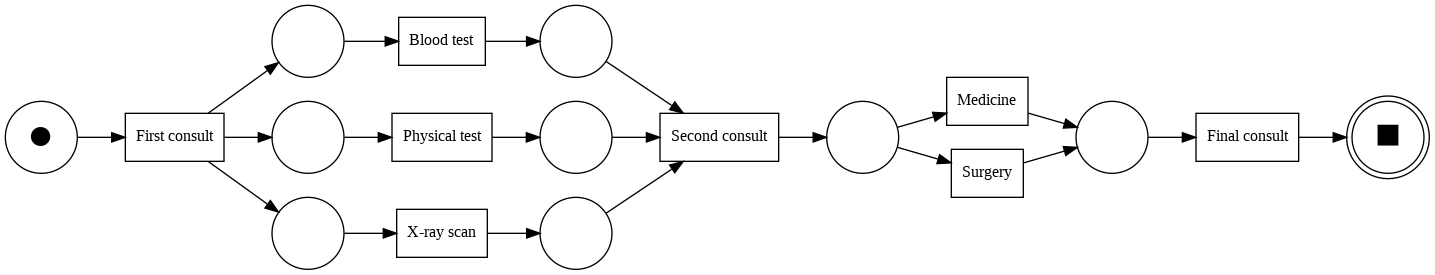

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

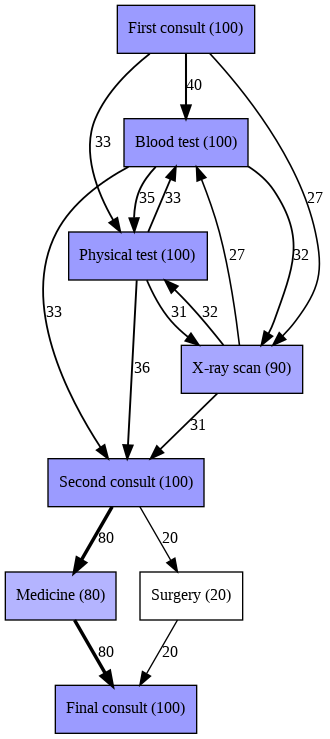

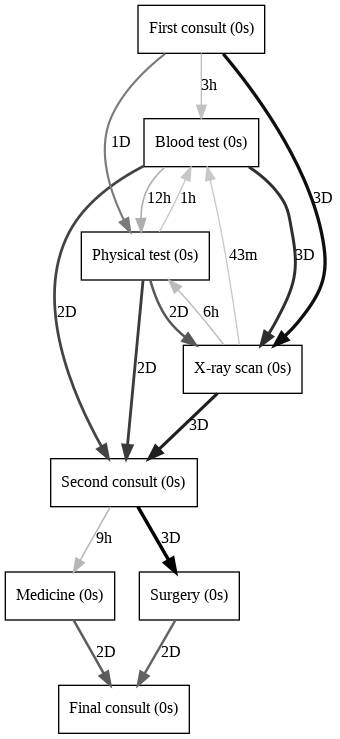

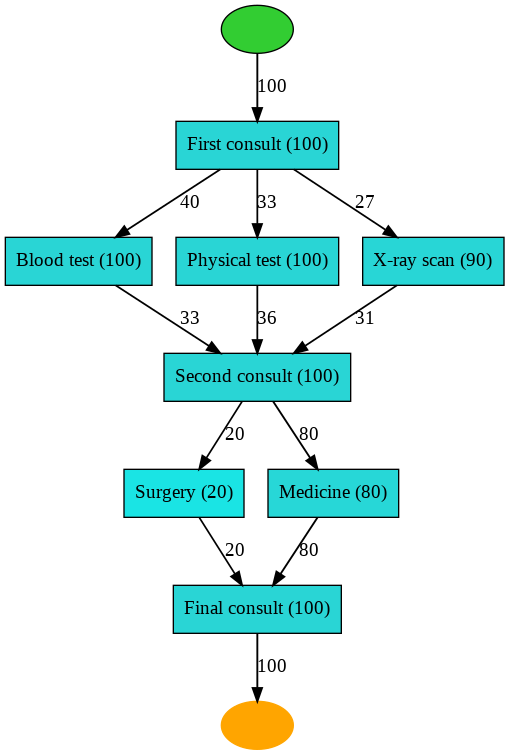

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

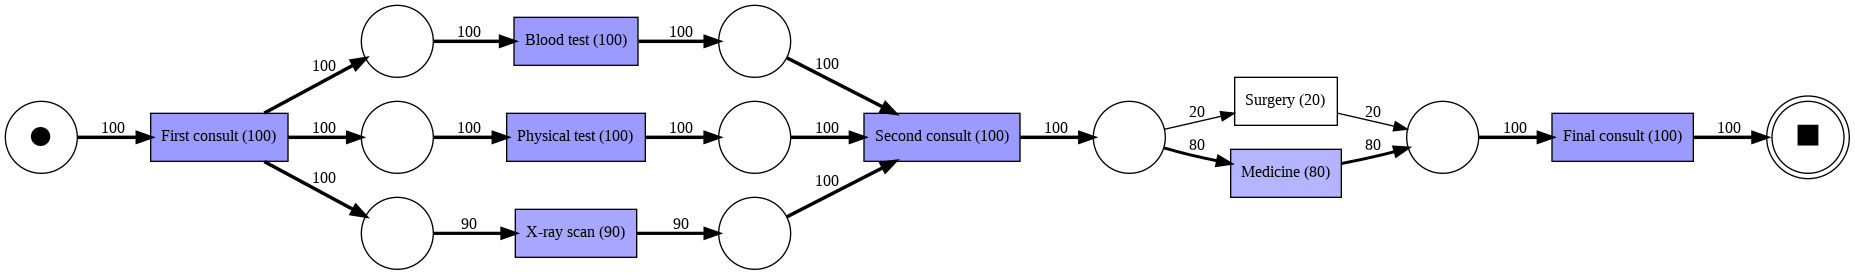

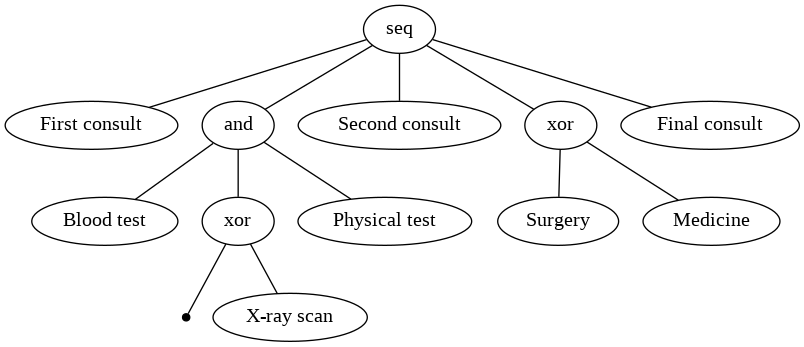

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

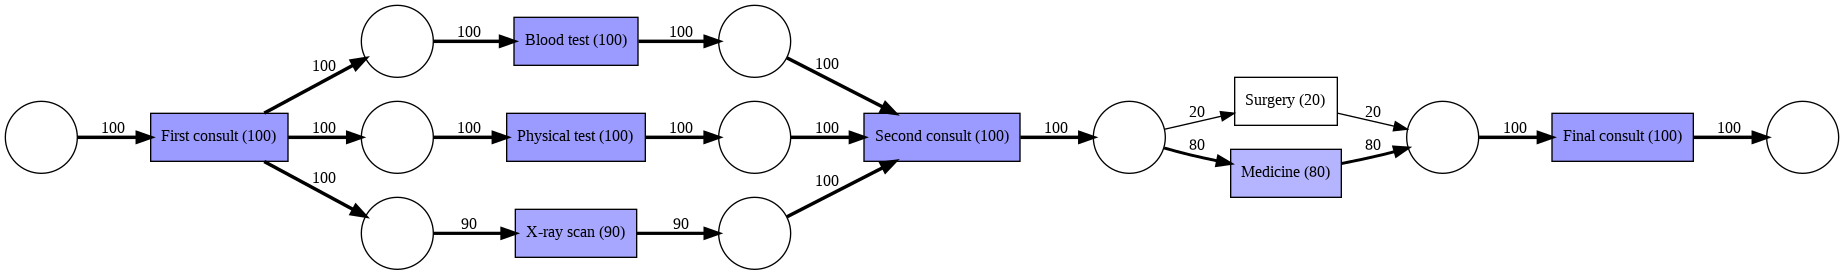

In [29]:

#  Most frequent event sequence
most_frequent_event = events['action_sequence'].value_counts().idxmax()


printmd('**The most frequent event (sequence) has** {} **activities.**'.format(len(most_frequent_event.split(delimiter))))
printmd('**The activity sequence is**:  {}.'.format(', '.join(most_frequent_event.split(delimiter)))) 
# Filtering events

# Removing events that all patients share
 ## Visualise which events are common to patients
patient_events = pd.crosstab(events['patient'], events['action'])
sns.heatmap(patient_events, cmap="YlGnBu")

nunique = patient_events.apply(pd.Series.nunique)
shared_actions = nunique[nunique==1].index
actions_to_keep = nunique[nunique>1].index
printmd('**The following actions are common to all cases**: {}'.format(', '.join(shared_actions)))
printmd('**The following actions are the ones that we wish to keep (not common to all cases)**: {}'.format(', '.join(actions_to_keep)))
  #filtered = events[events['action']=='X-ray scan']
filtered = events[events['action'].isin(actions_to_keep)]
printmd('**The filtered data has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))

filtered = filtered[filtered['action']!='X-ray scan']
printmd('**The filtered data excluding X-rays has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))

filtered = filtered[~filtered['resource'].isin([' Team 1', ' Team 2'])]
printmd('**The filtered data excluding team 1 and team 2 has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))

patient_events = pd.crosstab(filtered['patient'], filtered['action'])
#sns.heatmap(patient_events, cmap="YlGnBu")  printmd('**The filtered data has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))
printmd('**This amounts to** {} **cases with** {} **distinct actions.**'.format(patient_events.shape[0], patient_events.shape[1]))
printmd('**There are** {} **events.**'.format(np.sum(np.array(patient_events))))  
#Process Mining

# Check out this introduction to process mining in Python.Documentation for pm4py
 #!pip install pm4py --user
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter  
eventlog = events.copy()
### Specify which columns correspond to case (case:concept:name), 
###event (concept:name) and timestamp (time:timestamp) - rename columns in accordance
###with pm4py

eventlog.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)
 # Alpha miner
 # alpha miner
net, initial_marking, final_marking = alpha_miner.apply(log)

# Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)  # add information about frequency to the viz 
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# save the Petri net
pn_visualizer.save(gviz, "alpha_miner_healthcare_petri_net.png")  
#Directly-follows graph
 #Create graph from log
dfg = dfg_discovery.apply(log)

# viz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz) 
# With average times between nodes (performance) # creatig the graph from log
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)

# viz
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)  
#Heuristic miner
 # heuristics miner
heu_net = heuristics_miner.apply_heu(log)

# viz
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)  
#Petri-net of heuristic miner output # heuristics miner
net, im, fm = heuristics_miner.apply(log)

# viz
gviz = pn_visualizer.apply(net, im, fm)
gviz = pn_visualizer.apply(net, im, fm, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)
#pn_visualizer.view(gviz)
pn_visualizer.view(gviz)  
#Inductive miner
# create the process tree
tree = inductive_miner.apply(log)

# viz
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)  
#Petri-net of inductive miner output # convert the process tree to a petri net
#net, initial_marking, final_marking = pt_converter.apply(tree)


# alternatively, use the inductive_miner to create a petri net from scratch
# net, initial_marking, final_marking = inductive_miner.apply(log)

# viz
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)
pn_visualizer.view(gviz)

#pn_visualizer.save(gviz, "inductive_miner_healthcare_petri_net.png")  
#dir(net)  

#from pm4py.objects.petri_net import performance_map
#traces = performance_map.get_transition_performance_with_token_replay(log, net, initial_marking, final_marking)  #dir(traces)
#traces  Time between second consultation and surgery

# Mean in daysMinimum in hoursMaximum in days
# surgery_time = traces['Surgery']['all_values']
# seconds_to_days = 60*60*24
# seconds_to_hours = 60*60
# printmd('**Mean time to surgery**: {:.0f} days'.format(np.mean(surgery_time)/seconds_to_days))
# printmd('**Max time to surgery**: {:.0f} days'.format(np.max(surgery_time)/seconds_to_days))
# printmd('**Min time to surgery**: {:.0f} days, i.e. {:.0f} hours'.format(np.min(surgery_time)/seconds_to_days, np.min(surgery_time)/seconds_to_hours))
# printmd('**Min time to surgery**: {:.0f} days, i.e. {:.3f} hours'.format(np.min(surgery_time)/seconds_to_days, np.min(surgery_time)/seconds_to_hours))
# printmd('**Mean time to surgery**: {:.0f} days, i.e. {:.3f} hours'.format(np.mean(surgery_time)/seconds_to_days, np.mean(surgery_time)/seconds_to_hours))
# printmd('**Max time to surgery**: {:.0f} days, i.e. {:.3f} hours'.format(np.max(surgery_time)/seconds_to_days, np.max(surgery_time)/seconds_to_hours))
# sns.distplot(surgery_time)  

#Social Networks

#See this guide on using pm4py to analyse social networks
%matplotlib inline
#!pip install pyvis
# from pm4py.visualization.sna import visualizer as sna_vis
# from pm4py.algo.enhancement.sna import factory as sna_factory
# import sys
# import networkx as nx
# from pyvis import network as net

# g = net.Network(notebook=True)


# print(dir(sna_vis))
# print(dir(sna_vis.networkx))
# handover_nw = sna_factory.log_handover.apply(log)
# gviz_hw_py = sna_vis.networkx.apply(handover_nw)
#gnx = nx.Graph(gviz_hw_py)
#g.from_nx(gnx)
#g.show()
# sna_vis.networkx.view(gviz_hw_py)